<h1>Predicting Customer Purchase Frequency: The Impact of Age, Income, and Spending</h1>


<h2><span style='background:#CAFFBF'>Introduction:</span></h2>

<div style="text-align: justify">
Understanding consumer purchase frequency is of paramount importance for businesses seeking success in competitive markets. Purchase frequency, defined as the number of times a customer makes a purchase within a specific time period, holds valuable insights into customer behavior, enabling companies to shape effective marketing strategies and enhance overall profitability. Consequently, a pressing question arises: How can we accurately comprehend and predict customers' purchase frequency?
    <br><br> In a study by Kholis & Ma’rifa (2021), income emerged as a crucial determinant of consumer purchase frequency, with higher incomes generally associated with increased purchase frequency. However, intriguingly, the researchers noted that some individuals pursue a lifestyle-driven approach to consumption, irrespective of their income level (Kholis & Ma’rifa, 97). This intriguing dynamic suggests that while income often wields significant influence over spending patterns, exceptions rooted in individual needs and desires can occur. By delving into the effect of income within our dataset, we can identify distinct consumer profiles, illuminating these exceptional cases.
    <br><br> Furthermore, as anticipated, a consistent positive relationship surfaces between spending and purchase frequency. While it is logical to assume that consumers who spend more also engage in more frequent purchases, this assumption may be challenged when considering significant investments such as homes or cars. A consumer making fewer yet pricier purchases may exhibit a lower purchase frequency compared to someone making numerous smaller purchases. Notably, the financial stability typically accompanying age raises an intriguing hypothesis: older individuals may exhibit higher spending but lower purchase frequency. Thus, spending assumes a pivotal role in comprehending purchase frequency. 
    <br><br>Age potentially acts as a confounding variable, exerting its influence on income, spending, and purchase frequency. A study by Lennon et al. (2003) investigating customers' clothing spending habits revealed a positive relationship between age and purchase frequency, with frequency increasing in tandem with age. This finding prompts further exploration into the role of age as an influential factor within our dataset.
    <br><br>In light of these considerations, our research question aims to ascertain the extent to which consumer purchase frequency can be accurately predicted based on age, income, and spending habits. By investigating the relationships between these key predictors, we seek to provide valuable insights for businesses to enhance their understanding of customer behavior and inform effective marketing strategies. Our hypothesis posits a positive relationship between each predictor—age, income, and spending—and purchase frequency within our dataset. 
    <br><br>To facilitate our investigation, we  will utilize the Customer Spending Dataset obtained from Kaggle (accessible via the provided link) to create a classification model that attempts to predict customers' purchase frequency. This dataset includes the variables age, gender, education level, income, country of residence, purchase frequency, and spending amounts, but we will only include age, income, spending and purchase frequency for our model. The dataset represents purchase frequency on a scale ranging from 0.1 (least often) to 1.0 (most often). The dataset consists of an equal distribution of male and female customers, with ages ranging from 18 to 65. Incomes range from approximately \$20,000 to \$99,800 while spending is distributed between approximately \$611 and \$25,000. 
</div>
 
> Dataset Link: https://www.kaggle.com/datasets/goyaladi/customer-spending-dataset 


<h2><span style='background:#9BF6FF'>Methods & Results:</span></h2>

The methodology implemented in our project is as follows:
<br>
1. Load the dataset from Kaggle. 
2. Clean the data.
3. Wrangle the data into a format suitable for analysis.
4. Create the Training and Testing data sets.
5. Understand the Training data set using summary statistics and visualizations of variable distributions. 
6. Develop and fine tune a knn-classification model. 
7. Test the model's accuracy. 
8. Create visualizations of the analysis.  

We document our code at each step to clearly explain our process and ensure our analysis is replicable. 

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(broom)
library(ggplot2)
library(dplyr)
set.seed(3456)
options(repr.plot.width = 10, repr.plot.height = 5)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
# STEP 1: Read data into project via url. 
data <- read_csv("https://raw.githubusercontent.com/Kaylan-W/Dsci_project/main/data/customer_data.csv")

# STEP 2: The data will be cleaned by removing unused columns and handling NA values. 
data_downsized<- data %>%
        select(-name, -country, -gender, -education) %>%
        na.omit()

# STEP 3: The data will be wrangled by creating a categorical variable from the column purchase_frequency.
# The existing range of values for purchase_frequency were split into 4 numerical sub categories then given the 
# labels Very Low, Low, High and Very High.
breakpoints <- c(0, 0.25, 0.5, 0.75, 1)
labels <- c("Very Low", "Low", "High", "Very High")
tidydata<- data_downsized %>% mutate(pf_categories = cut(data_downsized$purchase_frequency, 
                                                    breakpoints, labels = labels, include.lowest = TRUE)) 

# STEP 4: Split data into training and testing data sets. 75% of the data will be put into the training set.
data_split <- initial_split(tidydata, prop = 0.75, strata = pf_categories)  
train_split <- training(data_split)   
test_split <- testing(data_split)

# STEP 5.1: Create Summary Table for the training set.
summary_table <- train_split %>%
  group_by(pf_categories) %>%
  summarize(count = n(),
            age_mean = mean(age),
            age_sd = sd(age),
            income_mean = mean(income),
            income_sd = sd(income),
            spending_mean = mean(spending),
            spending_sd = sd(spending)) %>%
  arrange(desc(count))

Rows: 1000 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): name, gender, education, country
dbl (4): age, income, purchase_frequency, spending

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Table 1: Head of the Training Data Set  

In [49]:
head(train_split)

age,income,purchase_frequency,spending,pf_categories
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
49,82468,0.6,12674.040,High
34,32225,0.7,6727.875,High
19,48896,0.6,5666.880,High
56,31997,0.6,12959.910,High
48,66812,0.7,14238.420,High
32,94468,0.7,15906.380,High


#### Table 2: Summary Statistics for the Training Data Set  

In [50]:
summary_table

pf_categories,count,age_mean,age_sd,income_mean,income_sd,spending_mean,spending_sd
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Low,221,40.84615,13.68389,56969.54,22453.04,6957.559,2334.900
Very High,216,41.44907,13.83515,59923.15,24005.60,15345.161,3699.308
High,171,42.51462,13.55657,58869.29,23301.60,11257.531,2737.969
Very Low,141,40.64539,14.39749,60063.39,24019.84,2432.809,1021.301


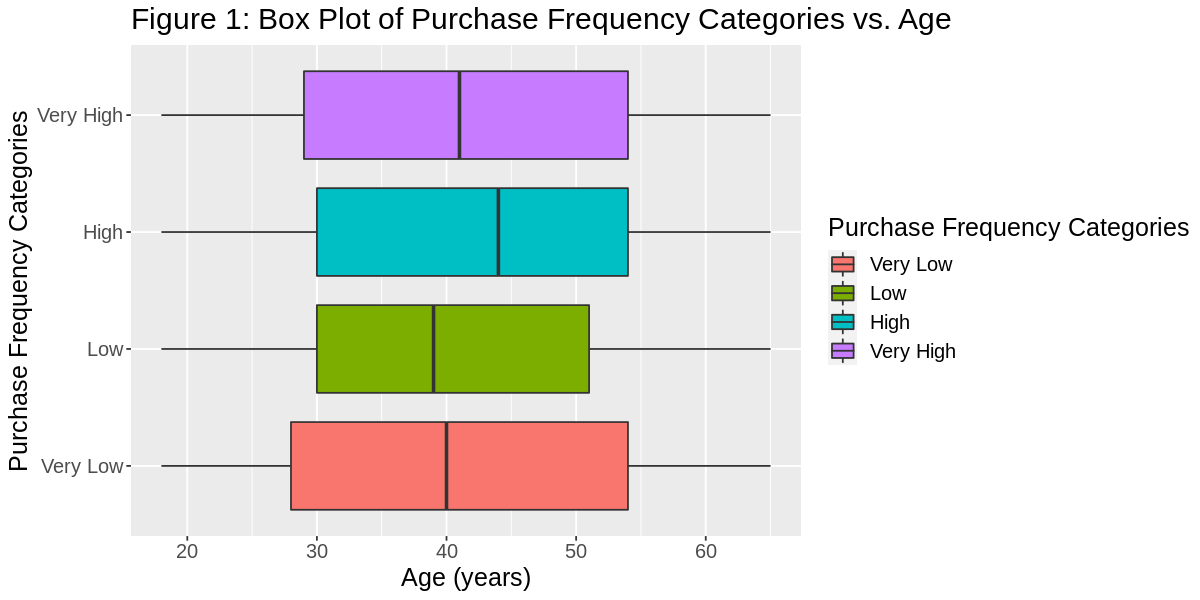

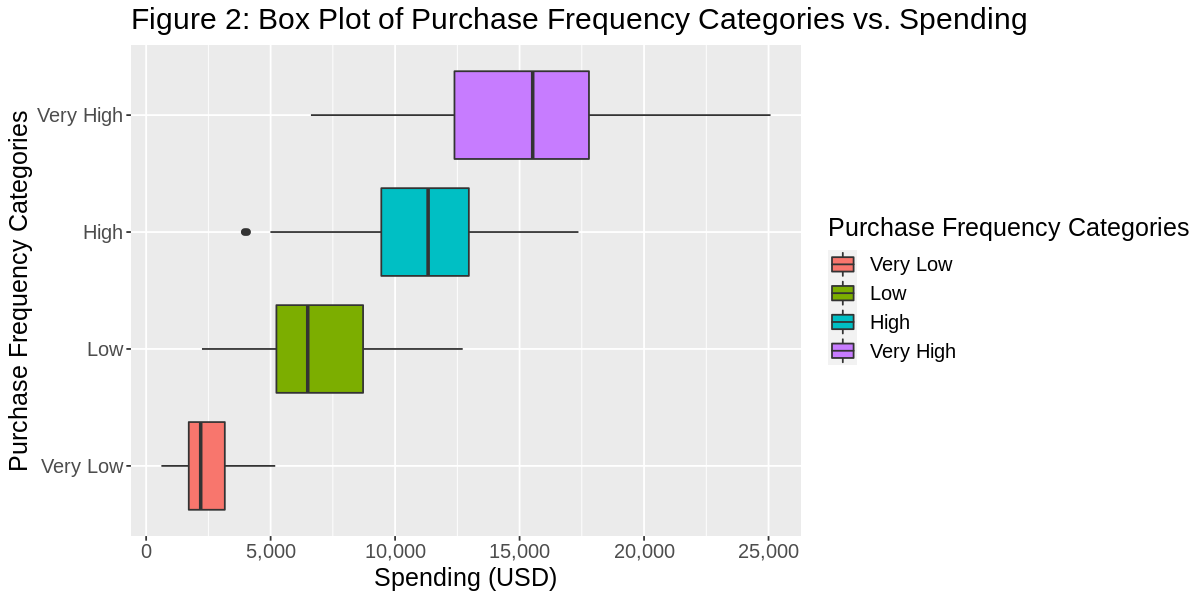

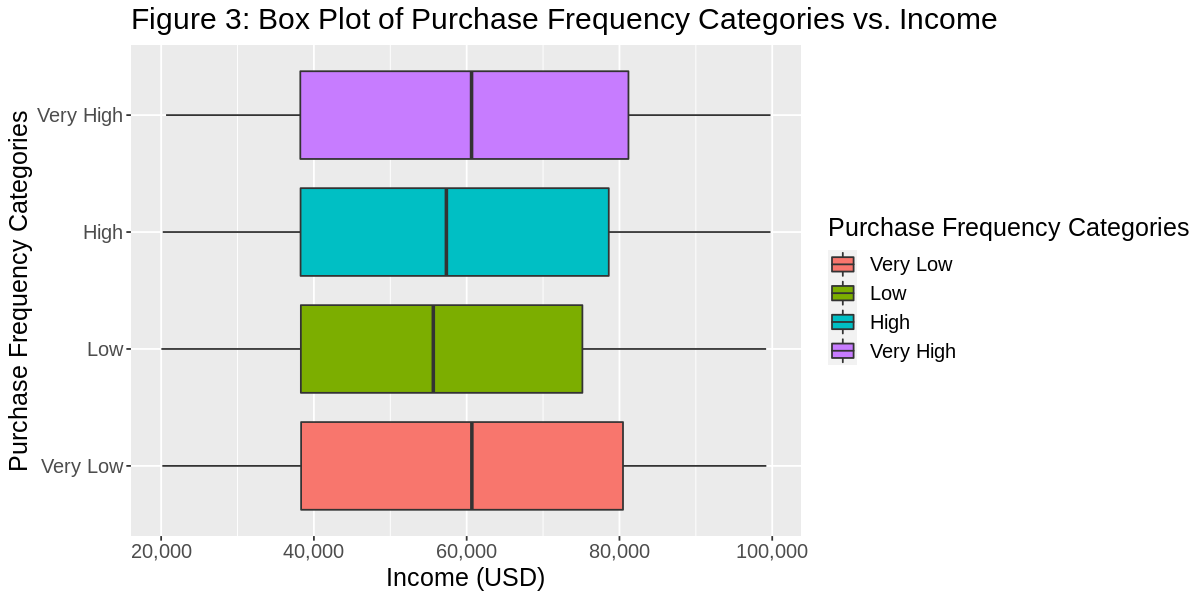

In [51]:
# STEP 5.2: Create visualizations of the distribution of the variables age, spending, and income within the training set.
age_plot<- ggplot(train_split, aes(x = age, y = pf_categories, fill = pf_categories)) +
  geom_boxplot() +
  labs(x = 'Age (years)', y = 'Purchase Frequency Categories', fill = 'Purchase Frequency Categories',
       title = 'Figure 1: Box Plot of Purchase Frequency Categories vs. Age') +
  theme(text = element_text(size = 15))
age_plot

spending_plot<- ggplot(train_split, aes(x = spending, y = pf_categories, fill = pf_categories)) +
  geom_boxplot() +
  labs(x = 'Spending (USD)', y = 'Purchase Frequency Categories', fill = 'Purchase Frequency Categories',
       title = 'Figure 2: Box Plot of Purchase Frequency Categories vs. Spending') +
  theme(text = element_text(size = 15)) +
  scale_x_continuous(labels = scales::comma)
spending_plot

income_plot<- ggplot(train_split, aes(x = income, y = pf_categories, fill = pf_categories)) +
  geom_boxplot() +
  labs(x = 'Income (USD)', y = 'Purchase Frequency Categories', fill = 'Purchase Frequency Categories',
       title = 'Figure 3: Box Plot of Purchase Frequency Categories vs. Income') +
  theme(text = element_text(size = 15)) +
  scale_x_continuous(labels = scales::comma)
income_plot

<div style="text-align: justify">
    We created box plots for each potential predictor variable (income, spending, age) to compare with the summary table above and determine which to use in our classfication models. Visualizing the distribution of each variable within the purchase frequency categories will allow us to see which variables have an effect. 
The above three boxplots indicate that both spending and age have an impact on consumer spending frequency, while income does not show a significant effect. 
    <br><br>According to the summary table mean and the box plot median, individuals in the high spending category tend to be slightly older, with an average age of 53 years, compared to the low, very low, and very high spending categories, where the average age is around 50 years. The age distribution across these categories is quite similar, with a standard deviation of approximately 13 years.
    <br><br>There is a strong positive correlation observed between spending and purchase frequency. Individuals who spend less tend to purchase less frequently, while those who spend more tend to purchase more frequently. The means of the spending categories, as shown in the summary table, exhibit greater variability compared to the age variable, ranging from \$2,516 to \$15,531 annually. Similarly, the median values in the box plots also vary significantly, ranging from around \$2,400 to \$15,500. Additionally, there is more variation within each spending category, as indicated by the standard deviation. The Very Low spending category has the lowest standard deviation of \$1,018, whereas the Very High spending category has the highest standard deviation of \$3,706.
    <br><br>The income box plot reveals the least significant findings. The means in the summary table for the income categories all fall within the range of \$58,000 to \$60,000 per year, and the medians in the box plot are slightly below or slightly above \$60,000 per year. The variation within the income categories is also not substantial, with standard deviation values ranging between \$22,500 and \$24,000.
</div>


In [11]:
# STEP 6.1: Create a recipe that centres and scales all predictors.
purchase_recipe <- recipe(pf_categories ~ age + spending + income, data = train_split) |> 
            step_scale(all_predictors()) |>
            step_center(all_predictors())

# STEP 6.2: Create a knn specification.
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
            set_engine("kknn") |> 
            set_mode("classification")

# STEP 6.3: Implement 5-fold cross validation, varying the number of neigbours from 1 to 20.
k_vals <- tibble(neighbors = 1:20)
purchase_vfold <- vfold_cv(train_split, v = 5, strata = pf_categories)

# STEP 6.4: Calculate the estimated accuracy of all computed models.
knn_workflow <- workflow() |>
  add_recipe(purchase_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = purchase_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies <- knn_workflow |>
  filter(.metric == "accuracy")


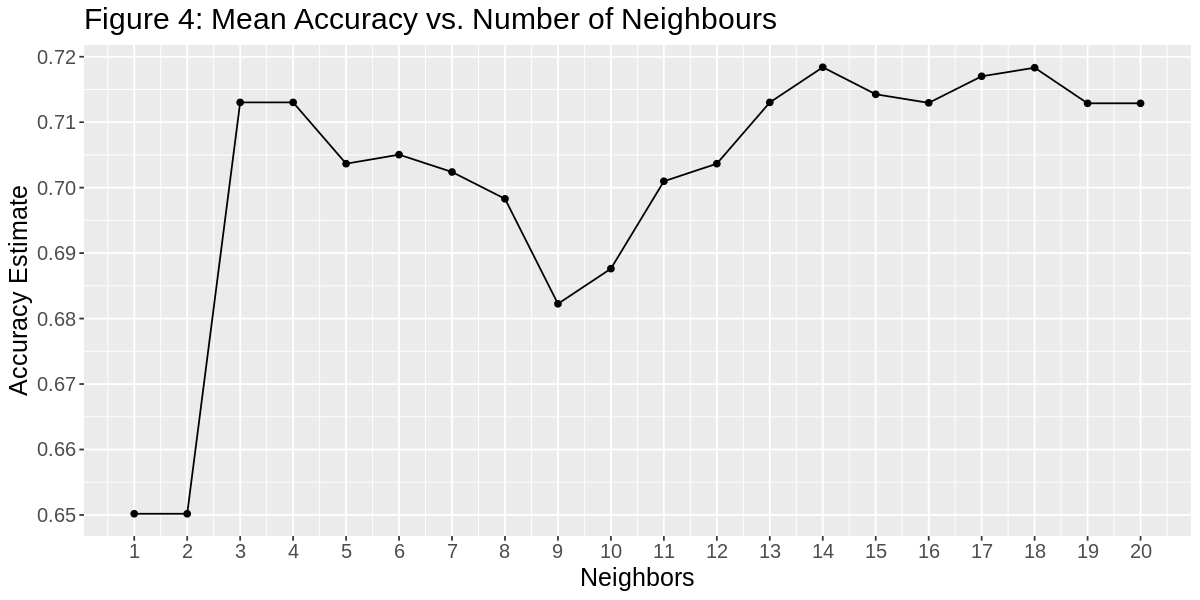

In [12]:
# STEP 6.5: Visualize and compare the estimated accuracy of all computed models to determine the best value for k.
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "Figure 4: Mean Accuracy vs. Number of Neighbours") + 
  scale_x_continuous(breaks = seq(0, 20, by = 1)) +  # adjusting the x-axis
  scale_y_continuous(breaks = seq(0, 1.5, by = 0.01)) + # adjusting the y-axis
  theme(text = element_text(size = 15))
accuracy_vs_k 

According to Figure 4, the best value to use for k (between 1 and 20) is 14. This is the k value that will be used in our final model. Though there are similar accuracy estimates with k values > 14, using a larger value poses the risk of creating an overfitted model. 

In [116]:
# STEP 6.5: Create another model with the best parameters. 
kkn_spec2<-nearest_neighbor(weight_func = "rectangular", neighbors= 14) |>
       set_engine("kknn") |>
       set_mode("classification")

knn_workflow2 <- workflow() |>
  add_recipe(purchase_recipe) |>
  add_model(kkn_spec2) |>
  fit(data = train_split)

# STEP 7: Use the model on the test data and assess its accuracy. 
purchase_predict <- knn_workflow2 |>
        predict(test_split) |>
        bind_cols(test_split) 

purchase_metrics <- purchase_predict |>
        metrics(truth = pf_categories, estimate = .pred_class)|>
        filter(.metric == "accuracy") |>
        select(.estimate) |>
        pull()

purchase_conf_mat <- purchase_predict |> 
      conf_mat(truth = pf_categories, estimate = .pred_class)

# STEP 8: Create visualizations of the results. 
# Create a new dataframe that has a column which compares the predictions to true values and returns true or false
predict_labels <- purchase_predict |>
                        mutate(prediction_status = .pred_class == pf_categories) 

predict_percent <- predict_labels |>
                        count(pf_categories, prediction_status) |>
                        rename(count = n) |> 
                        group_by(pf_categories) |> 
                        mutate(percentage = count / sum(count) * 100)

# Bar plot with percentage labels for the true and false predictions in each purchase frequency category
predict_dist <- ggplot(predict_percent, 
                    aes(x = pf_categories, y = count, fill = prediction_status)) +
                      geom_bar(stat = "identity", position = "stack") +
                      geom_text(aes(label = paste0(round(percentage), "%")), position = position_stack(vjust = 0.5)) +
                      labs(x = "Purchase Frequency Categories", y = "Number of Observations", fill = "Prediction Result",
                               title = "Figure 5: True and False Predictions by Purchase Frequency Category") +
                      scale_fill_manual(values = c("TRUE" = "#CAFFBF", "FALSE" = "#FF6961")) +
                      theme(text = element_text(size = 15))

# Calculate the average age, income, purchase frequency and spending for each purchase frequency category 
# amongst only true predictions  
summary_stats_by_pf <- predict_labels |> 
  filter(prediction_status == "TRUE") |> 
  group_by(pf_categories) |> 
  summarize(average_age = mean(age),
            average_income = mean(income),
            average_purchase_frequency = mean(purchase_frequency),
            average_spending = mean(spending))

#### Table 3: Confusion Matrix for the Final Model when Run on the Testing Set  

In [118]:
purchase_conf_mat

cat("\n\nModel Accuracy on Testing Set:", purchase_metrics* 100)

           Truth
Prediction  Very Low Low High Very High
  Very Low        43   6    0         0
  Low              4  58   13         2
  High             0   9   21        13
  Very High        0   1   23        58



Model Accuracy on Testing Set: 71.71315

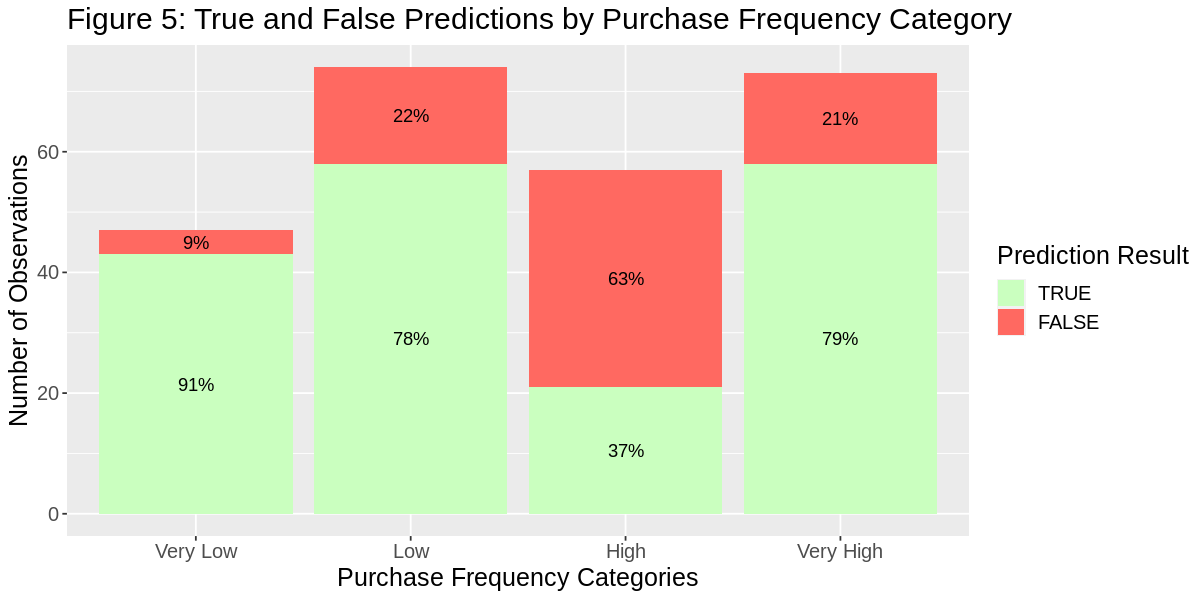

In [117]:
predict_dist

#### Table 4: Average Variable Values for Each Correctly Predicted Purchase Frequency Category

In [110]:
summary_stats_by_pf

pf_categories,average_age,average_income,average_purchase_frequency,average_spending
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Very Low,43.72093,54732.74,0.1348837,2406.671
Low,42.34483,65124.38,0.3965517,6892.417
High,43.90476,64283.76,0.6714286,11580.832
Very High,43.44828,59559.95,0.9155172,17233.847


<h2><span style='background:#BDB2FF'>Discussion:</span></h2>

<div style="text-align: justify">
Using Table 3, Table 4, and Figure 5, we can deduce the key findings of our investigation. Our model had an accuracy of approximately 72% on the training data. Figure 5 shows that the model has the greatest difficulty predicting observations that were supposed to be in the "High" category, as it only correctly predicted 37% of observations. This may indicate that our model was not complex enough to accurately identify consumers in the "High" category. Perhaps there may other variables besides age, income and spending that have a significant influence specifically on this purchase frequency category. This is an area for further future analysis, where we can attempt to better understand the consumer profile of persons in this category. 
    <br><br>Our hypothesis was that there would be a positive relationship between each predictor — age, income, and spending — and purchase frequency within our dataset. This pattern is not very clear with the reltionship between age and purchase frequency. The pattern is clear regarding spending and purchase frequency, as we can see from Table 4 that the average spending increased with each increase in purchase frequency. There is certainly a strong positive correlation between these two variables.   
    <br><br>The relationship between income and purchase frequency is also not as expected. The "Low" purchase frequency category had the highest average income, which we would have expected the "Very High" category to have. The group with the highest average purchase frequency (0.92) had an average income of \$59,559.95, which was the second lowest income group. This may speak to the influence of lifestyle on purchase frequency as suggested by Kholis & Ma’rifa (2021). These consumers had a low income but the highest purchase frequency, which may be attributed to social pressure to "fit in" and live a particular lifestyle. This is also an area for further research, to understand the correlation between lifestyle, purchase frequency and income. 
    <br><br>Our findings can be useful to companies who are developing marketing schemes as it gives them an idea of which demographics they should cater to to meet their goals. Companies that want to increase consumer's purchase frequency and the likelihood of returning consumers ought to focus on those who spend alot but are in a middle class income bracket. 
    <br><br>Overall, these results indicate that purchase frequency is influenced by a combination of factors beyond age, income, and spending alone. It would be important to explore additional variables or factors that might have a stronger association with purchase frequency in order to gain a more comprehensive understanding of the underlying drivers. It is also important to recognize the limitations of our investigation, such as the size of the data set, which may prevent our results from being widely generalized. 
</div>

<h2><span style='background:#FFC6FF'>References:</span></h2>

Kholis, N., &amp; Ma’rifa, A. (2021, November 19). The influence of price and income on purchase decisions among fast-food consumers: The mediating effect of lifestyle. https://www.unisza.edu.my/icbm2021/images/PROGRAM_BOOK/PAPER_12.pdf 

Lennon, S. J., Sanik, M. M., &amp; Stanforth, N. F. (2003). Motivations for television shopping: Clothing purchase frequency and personal characteristics. Clothing and Textiles Research Journal, 21(2), 63–74. https://doi.org/10.1177/0887302x0302100202 


